#Import Packages

In [122]:
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from tensorflow.keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

# Read Dataset (Train, Test)

In [12]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
train_dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [13]:
train_dataset = train_dataset.sample(frac = 1)

In [14]:
train_dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
30183,a14e19a6d618,D8EAAA9AB53B,Another example is that a friend has not only ...,Evidence,Effective
29870,5ac78ac89d1c,D279FF9C83D7,our country is already lazy enough.,Claim,Adequate
28448,3f33c26d6ce0,BB3EBEF87BBB,But many still believe that it is alien. Even ...,Evidence,Ineffective
4217,ff86124f7bb9,4AEA13D034F3,There are a lot of things that can back this u...,Evidence,Ineffective
23630,af75f669e28c,7A2D0B189298,"Many my agrue that, the Electoral college is t...",Counterclaim,Ineffective


In [15]:
train_dataset.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,a14e19a6d618,900A879708F0,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [16]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36765 entries, 30183 to 36346
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [18]:
# for test
test_dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [19]:
discourse_text = train_dataset['discourse_text']
discourse_type = train_dataset['discourse_type']
labels = train_dataset['discourse_effectiveness']

In [20]:
# for test
discourse_text_test = test_dataset['discourse_text']
discourse_type_test = test_dataset['discourse_type']

In [21]:
discourse_text = discourse_text.str.strip()

In [22]:
# for test
discourse_text_test = discourse_text_test.str.strip()

In [23]:
discourse_text

30183    Another example is that a friend has not only ...
29870                  our country is already lazy enough.
28448    But many still believe that it is alien. Even ...
4217     There are a lot of things that can back this u...
23630    Many my agrue that, the Electoral college is t...
                               ...                        
8788     student designed is better because they should...
33442    It is obvious that almost every student has a ...
5262     For example, working in the yearbook committee...
27029    Al Gore ran for President and won by popular v...
36346    How an online class works is that it's held at...
Name: discourse_text, Length: 36765, dtype: object

In [24]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  return sentences

In [25]:
discourse_text = CleanFeatures(discourse_text)

In [26]:
# for test
discourse_text_test = CleanFeatures(discourse_text_test)

In [27]:
discourse_text.head()

30183    Another example is that a friend has not only ...
29870                   our country is already lazy enough
28448    But many still believe that it is alien Even t...
4217     There are a lot of things that can back this u...
23630    Many my agrue that the Electoral college is th...
Name: discourse_text, dtype: object

In [28]:
# for test
discourse_text_test.head()

0    Making choices in life can be very difficult P...
1    Seeking multiple opinions can help a person ma...
2                        it can decrease stress levels
3                a great chance to learn something new
4                   can be very helpful and beneficial
Name: discourse_text, dtype: object

In [29]:
discourse_type.head()

30183        Evidence
29870           Claim
28448        Evidence
4217         Evidence
23630    Counterclaim
Name: discourse_type, dtype: object

In [30]:
discourse_type.unique()

array(['Evidence', 'Claim', 'Counterclaim', 'Concluding Statement',
       'Position', 'Lead', 'Rebuttal'], dtype=object)

In [31]:
labels

30183      Effective
29870       Adequate
28448    Ineffective
4217     Ineffective
23630    Ineffective
            ...     
8788        Adequate
33442      Effective
5262        Adequate
27029    Ineffective
36346    Ineffective
Name: discourse_effectiveness, Length: 36765, dtype: object

In [32]:
discourse_text.shape

(36765,)

In [33]:
text = np.asarray([discourse_type[index] + " "+ value for index, value in enumerate(discourse_text) ])

In [34]:
# for test
text_test = np.asarray([discourse_type_test[index] + " "+ value for index, value in enumerate(discourse_text_test) ])

In [35]:
text.shape

(36765,)

In [36]:
# for test
text_test.shape

(10,)

In [37]:
text

array(['Lead Another example is that a friend has not only told me but I have witnessed how much online schooling has benefited her for the better She is not as self conscious\xa0as she used to be due to the fact that she has gotten very used to being comfortable in her own skin and not having to listen to other peoples opinions\xa0In school she was a C and occasionally a D student because she was always leaving class to go speak with counselors about how people would make jokes about her and throw items at her because she looked different and was Arabian Since she switched to online schooling she is now an A and B student Furthermore she is about to graduate and get her diploma with a 30 GPA If she did not switch to online schooling would she be in this situation now',
       'Position our country is already lazy enough',
       'Claim But many still believe that it is alien Even though this some of the best evidence to peove the face on mars isnt alien but a mistake',
       ...,
   

In [38]:
text_test

array(['Lead Making choices in life can be very difficult People often ask for advice when they can not decide on one thing Its always good to ask others for their advice when making a choice When you have multiple opinions you have the ability to make the best choice for yourself',
       'Position Seeking multiple opinions can help a person make a better choice',
       'Claim it can decrease stress levels',
       'Claim a great chance to learn something new',
       'Claim can be very helpful and beneficial',
       'Evidence When making a decision there is a chance that you can become very stressed and overwhelmed Being stressed can cause a person to give up on what they are doing Having multiple opinions from people can make choosing an option less difficult and more easier The information that you receive from others may have a special meaning in the future Other peoples opinion can make a person feel confident in making the right choice',
       'Evidence Everyone is different 

In [39]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 82.9 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 79.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#Tokenizer Data (Train, Test)

In [40]:
from transformers import AutoTokenizer

In [41]:
sequence_length = [len(str(te).split()) for te in text]

In [42]:
SEQ_LEN = np.max(sequence_length)

In [43]:
SEQ_LEN

837

In [44]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [45]:
input_ids = []
attention_mask = []

In [46]:
# for test
input_ids_test = []
attention_mask_test = []

In [47]:
for index, value in enumerate(text):
  tokens = tokenizer.encode_plus(value, max_length= SEQ_LEN, padding = "max_length",
                                 truncation = True, return_token_type_ids = False,
                                 return_attention_mask = True, return_tensors = 'np')
  input_ids.append(tokens['input_ids'])
  attention_mask.append(tokens['attention_mask'])

In [48]:
# for test
for index, value in enumerate(text_test):
  tokens = tokenizer.encode_plus(value, max_length= SEQ_LEN, padding = "max_length",
                                 truncation = True, return_token_type_ids = False,
                                 return_attention_mask = True, return_tensors = 'np')
  input_ids_test.append(tokens['input_ids'])
  attention_mask_test.append(tokens['attention_mask'])

In [49]:
input_ids = np.asarray(input_ids)
attention_mask = np.asarray(attention_mask)

In [50]:
# for test
input_ids_test = np.asarray(input_ids_test)
attention_mask_test = np.asarray(attention_mask_test)

In [51]:
input_ids = input_ids.reshape(input_ids.shape[0], input_ids.shape[2])
attention_mask = attention_mask.reshape(attention_mask.shape[0], attention_mask.shape[2])

In [52]:
# for test
input_ids_test = input_ids_test.reshape(input_ids_test.shape[0], input_ids_test.shape[2])
attention_mask_test = attention_mask_test.reshape(attention_mask_test.shape[0], attention_mask_test.shape[2])

In [53]:
attention_mask.shape

(36765, 837)

In [54]:
input_ids.shape

(36765, 837)

In [55]:
input_ids

array([[  101, 10440,  2543, ...,     0,     0,     0],
       [  101, 18959,  5053, ...,     0,     0,     0],
       [  101,   140, 20737, ...,     0,     0,     0],
       ...,
       [  101, 18959,  5053, ...,     0,     0,     0],
       [  101, 16573,  2586, ...,     0,     0,     0],
       [  101, 16752,  1665, ...,     0,     0,     0]])

In [56]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [57]:
# for test
input_ids_test

array([[  101, 10440, 10697, ...,     0,     0,     0],
       [  101, 18959,  5053, ...,     0,     0,     0],
       [  101,   140, 20737, ...,     0,     0,     0],
       ...,
       [  101,   140, 20737, ...,     0,     0,     0],
       [  101, 16573,  9251, ...,     0,     0,     0],
       [  101, 16752,  1665, ...,     0,     0,     0]])

In [58]:
# for test
input_ids_test.shape

(10, 837)

In [59]:
label_ = LabelEncoder()
labels = label_.fit_transform(labels)
labels = to_categorical(labels)

In [60]:
classes_names = list(label_.classes_)
classes_names

['Adequate', 'Effective', 'Ineffective']

In [61]:
labels.shape

(36765, 3)

In [62]:
input_ids.shape

(36765, 837)

In [63]:
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels))

In [64]:
labels_zeros_test = tf.zeros((10, 3), dtype = 'int32')

In [65]:
# for test
dataset_test = tf.data.Dataset.from_tensor_slices((input_ids_test, attention_mask_test, labels_zeros_test))

In [66]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(837,), dtype=int64, numpy=
array([  101, 10440,  2543,  1859,  1110,  1115,   170,  1910,  1144,
        1136,  1178,  1500,  1143,  1133,   146,  1138,  9491,  1293,
        1277,  3294, 15113,  1144, 21495,  1123,  1111,  1103,  1618,
        1153,  1110,  1136,  1112,  2191,  9701,  1112,  1131,  1215,
        1106,  1129,  1496,  1106,  1103,  1864,  1115,  1131,  1144,
        4690,  1304,  1215,  1106,  1217,  6062,  1107,  1123,  1319,
        2241,  1105,  1136,  1515,  1106,  5113,  1106,  1168,  7983,
       11089,  1130,  1278,  1131,  1108,   170,   140,  1105,  5411,
         170,   141,  2377,  1272,  1131,  1108,  1579,  2128,  1705,
        1106,  1301,  2936,  1114, 23550,  1116,  1164,  1293,  1234,
        1156,  1294, 13948,  1164,  1123,  1105,  4932,  4454,  1120,
        1123,  1272,  1131,  1350,  1472,  1105,  1108, 14223,  1967,
        1131,  6759,  1106,  3294, 15113,  1131,  1110,  1208,  1126,
         138,  1105,   139,  2377,  7282,  

In [67]:
def map_change_dataset(input_ids, attention_mask, labels):
  return {'input_ids':input_ids, 'attention_mask': attention_mask}, labels

In [68]:
dataset = dataset.map(map_change_dataset)

In [69]:
# for test
dataset_test = dataset_test.map(map_change_dataset)

In [70]:
for i in dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(837,), dtype=int64, numpy=
array([  101, 10440,  2543,  1859,  1110,  1115,   170,  1910,  1144,
        1136,  1178,  1500,  1143,  1133,   146,  1138,  9491,  1293,
        1277,  3294, 15113,  1144, 21495,  1123,  1111,  1103,  1618,
        1153,  1110,  1136,  1112,  2191,  9701,  1112,  1131,  1215,
        1106,  1129,  1496,  1106,  1103,  1864,  1115,  1131,  1144,
        4690,  1304,  1215,  1106,  1217,  6062,  1107,  1123,  1319,
        2241,  1105,  1136,  1515,  1106,  5113,  1106,  1168,  7983,
       11089,  1130,  1278,  1131,  1108,   170,   140,  1105,  5411,
         170,   141,  2377,  1272,  1131,  1108,  1579,  2128,  1705,
        1106,  1301,  2936,  1114, 23550,  1116,  1164,  1293,  1234,
        1156,  1294, 13948,  1164,  1123,  1105,  4932,  4454,  1120,
        1123,  1272,  1131,  1350,  1472,  1105,  1108, 14223,  1967,
        1131,  6759,  1106,  3294, 15113,  1131,  1110,  1208,  1126,
         138,  1105,   139,  

In [71]:
dataset = dataset.shuffle(500000).batch(84)

In [72]:
# for test
dataset_test = dataset_test.shuffle(500000).batch(84)

#Split Data Train into (train, validation):
training 80% for training

test 20% for test

In [73]:
training_split = 0.8
dataset_len = len(list(dataset))

In [74]:
data_train = dataset.take(round(training_split*dataset_len))
data_valid = dataset.skip(round(training_split*dataset_len))

# Transformers using Bert Model

In [78]:
from transformers import TFBertModel
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [71]:
input_ids_m = tf.keras.layers.Input(shape = (SEQ_LEN, ), name = "input_ids", dtype = 'int32')
attention_mask_n = tf.keras.layers.Input(shape = (SEQ_LEN, ), name = "attention_mask", dtype = 'int32')
bert_m = bert(input_ids_m, attention_mask = attention_mask_n)[0]
x = tf.keras.layers.LSTM(128, return_sequences= True)(bert_m)
x1 = tf.keras.layers.GlobalAveragePooling1D()(x)
x2 = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.concatenate([x1, x2])
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(len(classes_names), activation = "softmax")(x)

m = tf.keras.models.Model(inputs = [input_ids_m, attention_mask_n], outputs = y)

In [72]:
bert_m.shape

TensorShape([None, 837, 768])

In [73]:
m.layers[2].trainable = False

In [74]:
m.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 837)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 837)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 837,                                         

In [75]:
m.compile(loss="categorical_crossentropy",optimizer= "adam",metrics=[
    tf.keras.metrics.CategoricalAccuracy("accuracy"),
    TruePositives(name='tp'), 
    FalsePositives(name='fp'), 
    TrueNegatives(name='tn'), 
    FalseNegatives(name='fn'),
    Precision(name='precision'), 
    Recall(name='recall')
])

In [76]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min', restore_best_weights = True)

In [78]:
history_training = m.fit(data_train,
                         epochs= 42,
                         use_multiprocessing=True,
                         callbacks=[ earlyStopping])

Epoch 1/42
350/350 [==============================] - 1556s 4s/step - loss: 0.7669 - accuracy: 0.6589 - tp: 18442.0000 - fp: 8985.0000 - tn: 49815.0000 - fn: 10958.0000 - precision: 0.6724 - recall: 0.6273
Epoch 2/42
350/350 [==============================] - 1555s 4s/step - loss: 0.7438 - accuracy: 0.6684 - tp: 18813.0000 - fp: 8873.0000 - tn: 49927.0000 - fn: 10587.0000 - precision: 0.6795 - recall: 0.6399
Epoch 3/42
350/350 [==============================] - 1555s 4s/step - loss: 0.7310 - accuracy: 0.6724 - tp: 18963.0000 - fp: 8758.0000 - tn: 50042.0000 - fn: 10437.0000 - precision: 0.6841 - recall: 0.6450
Epoch 4/42
350/350 [==============================] - 1555s 4s/step - loss: 0.7119 - accuracy: 0.6807 - tp: 19228.0000 - fp: 8502.0000 - tn: 50298.0000 - fn: 10172.0000 - precision: 0.6934 - recall: 0.6540
Epoch 5/42
350/350 [==============================] - 1555s 4s/step - loss: 0.6961 - accuracy: 0.6899 - tp: 19575.0000 - fp: 8288.0000 - tn: 50512.0000 - fn: 9825.0000 - precis

# Result For training Dataset

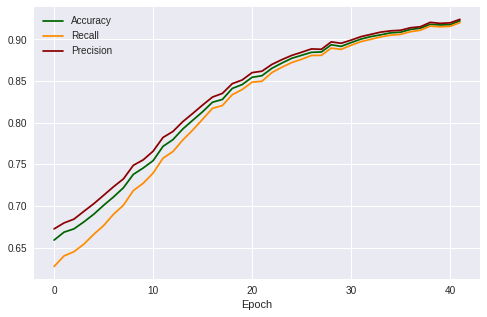

In [81]:
import matplotlib as mpl
mpl.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(history_training.history['accuracy'],"darkgreen", label= "Accuracy")
plt.plot(history_training.history['recall'], "darkorange", label= "Recall")
plt.plot(history_training.history['precision'], "darkred", label= "Precision")
plt.xlabel('Epoch')
plt.legend()

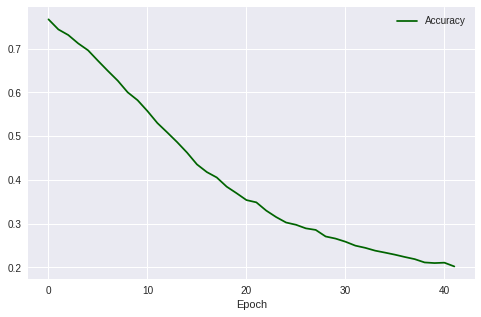

In [83]:
mpl.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(history_training.history['loss'],"darkgreen", label= "Accuracy")
plt.xlabel('Epoch')
plt.legend()

##Evaluate Validation:

In [84]:
m.evaluate(data_valid, use_multiprocessing=True)

88/88 [==============================] - 329s 4s/step - loss: 0.0666 - accuracy: 0.9815 - tp: 7221.0000 - fp: 131.0000 - tn: 14599.0000 - fn: 144.0000 - precision: 0.9822 - recall: 0.9804


[0.06664776057004929,
 0.9815343022346497,
 7221.0,
 131.0,
 14599.0,
 144.0,
 0.9821817278862,
 0.9804480671882629]

# Predict for Test Data

In [80]:
print(tf.__version__)

2.8.2


In [133]:
y_pred = m.predict(dataset_test, verbose= 1)

1/1 [==============================] - 3s 3s/step


In [134]:
y_pred

array([[3.32510233e-01, 6.67489767e-01, 2.80278717e-10],
       [9.59842384e-01, 3.80099565e-02, 2.14755139e-03],
       [4.53247517e-01, 5.46636581e-01, 1.15954172e-04],
       [9.49866712e-01, 5.01257405e-02, 7.63254866e-06],
       [9.41176474e-01, 5.86310774e-02, 1.92365420e-04],
       [1.80817828e-01, 8.18899453e-01, 2.82680063e-04],
       [9.26552399e-04, 9.99073267e-01, 8.30924094e-08],
       [5.81955433e-01, 4.18035597e-01, 9.04639182e-06],
       [9.55281734e-01, 4.47070003e-02, 1.12763655e-05],
       [5.31971514e-01, 4.19584066e-01, 4.84443642e-02]], dtype=float32)

In [135]:
y_pred = np.argmax(y_pred, axis = 1)

In [136]:
y_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [138]:
for i in y_pred:
  print(classes_names[i])

Effective
Adequate
Effective
Adequate
Adequate
Effective
Effective
Adequate
Adequate
Adequate


# sample_submission

In [110]:
res = [[3.32510233e-01, 6.67489767e-01, 2.80278717e-10],
       [9.59842384e-01, 3.80099565e-02, 2.14755139e-03],
       [4.53247517e-01, 5.46636581e-01, 1.15954172e-04],
       [9.49866712e-01, 5.01257405e-02, 7.63254866e-06],
       [9.41176474e-01, 5.86310774e-02, 1.92365420e-04],
       [1.80817828e-01, 8.18899453e-01, 2.82680063e-04],
       [9.26552399e-04, 9.99073267e-01, 8.30924094e-08],
       [5.81955433e-01, 4.18035597e-01, 9.04639182e-06],
       [9.55281734e-01, 4.47070003e-02, 1.12763655e-05],
       [5.31971514e-01, 4.19584066e-01, 4.84443642e-02]]
res = np.asarray(res)      

In [112]:
test_dataset['discourse_id']

0    a261b6e14276
1    5a88900e7dc1
2    9790d835736b
3    75ce6d68b67b
4    93578d946723
5    2e214524dbe3
6    84812fc2ab9f
7    c668ff840720
8    739a6d00f44a
9    bcfae2c9a244
Name: discourse_id, dtype: object

In [113]:
res_csv = pd.DataFrame({
    "discourse_id":test_dataset['discourse_id'],
    "Ineffective": res[:, 2].astype(float),
    "Adequate": res[:, 0].astype(float),
    "Effective": res[:, 1].astype(float)
    
})

In [118]:
res_csv.head(n=10)

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,2.802787e-10,0.332510,0.667490
1,5a88900e7dc1,2.147551e-03,0.959842,0.038010
2,9790d835736b,1.159542e-04,0.453248,0.546637
3,75ce6d68b67b,7.632549e-06,0.949867,0.050126
4,93578d946723,1.923654e-04,0.941176,0.058631
5,2e214524dbe3,2.826801e-04,0.180818,0.818899
6,84812fc2ab9f,8.309241e-08,0.000927,0.999073
7,c668ff840720,9.046392e-06,0.581955,0.418036
8,739a6d00f44a,1.127637e-05,0.955282,0.044707
9,bcfae2c9a244,4.844436e-02,0.531972,0.419584


In [119]:
res_csv.to_csv("sample_submission.csv")